## 一、高斯过程

### 1. $Gaussian$ $Process$

$\Rightarrow Definition:$

$对于一个连续的时间域T，在其上任选n个时刻t_1,t_2,..,t_n \in T，若得到的随机向量(X_1,X_2,..,X_n)服从n元高斯分布N_n(\vec\mu,\Sigma)，则称该随机过程为高斯过程$

$\Rightarrow Properties:$

$$\begin{equation}\begin{aligned}
&① 每个时刻对应的随机变量X_t均服从其对应的高斯分布N(\mu_t,\sigma_t^2)\\
&② 高斯过程本质上得到的是一个时间域上无限维的随机变量X_{\infty}，服从无限元高斯分布N_{\infty}(\vec\mu,\Sigma)\\
&③ 由于时间域的连续性，均值向量\vec\mu和协方差矩阵\Sigma均以时刻t的连续函数表示：\\
&\quad\quad \vec\mu = \mu(\vec t), \Sigma_k(\vec t) = \left[k(t_i,t_j)\right] = \left[\sigma^2\cdot \exp{\left(-\cfrac{\left\|t_i-t_j\right\|^2}{2r^2}\right)}\right],\forall i,j \in \{1,2,..\}\\
& \Rightarrow k(t_i,t_j)是协方差矩阵的核函数，通常选用如上所示的径向基函数(\mathrm{RBF})，其中\sigma,r都是其超参数
\end{aligned}\end{equation}
$$

In [86]:
## RBF gaussian kernel
import numpy as np

def RBF_kernel(T1,T2,sigma=1.0,r=1.0):
    
    def RBF(t1,t2,sigma=1.0,r=1.0):
        return sigma**2 * np.exp(
            -(t1-t2)**2/2*r**2
        )
    m = T1.shape[0]
    n = T2.shape[0]
    Sigma = np.zeros((m,n),dtype=np.float)
    for i in range(m):
        for j in range(n):
            Sigma[i][j] = RBF(T1[i],T2[j])
    return Sigma

T = np.array([1,3,7,9])
Sigma = RBF_kernel(T,T)
Sigma  

array([[1.00000000e+00, 1.35335283e-01, 1.52299797e-08, 1.26641655e-14],
       [1.35335283e-01, 1.00000000e+00, 3.35462628e-04, 1.52299797e-08],
       [1.52299797e-08, 3.35462628e-04, 1.00000000e+00, 1.35335283e-01],
       [1.26641655e-14, 1.52299797e-08, 1.35335283e-01, 1.00000000e+00]])

### 2. $Gaussian$ $Process$ $Regression$

$\Rightarrow Background: 给定一个高斯过程的n个时刻t_1,t_2,..,t_n的观测值y_1,y_2,..,y_n，回归这个高斯过程的分布N(\mu(\vec t),\Sigma(\vec t))$

$\Rightarrow Method:$

$$\begin{equation}\begin{aligned}
& ① 设n个时刻对应的随机向量为X，观测值对应的随机向量为Y，剩余非观测时刻对应的随机向量为\tilde{X}\\
& ② 易知X和X^*均服从高斯分布，且联合随机向量(X,\tilde{X})\sim N(\mu(\vec t),\Sigma_k(\vec t))\\
& ③ 又由高斯分布的条件分布公式：X^* = \tilde{X}|X\sim N(\vec\mu^*,\Sigma^*)，其中：\\
& \quad\quad\quad\quad \vec\mu^* = \mu(\tilde{X})+k(\tilde{X},X)k(X,X)^{-1}(Y-\mu(X)), \;\Sigma^*=k(\tilde{X},\tilde{X}) - k(\tilde{X},X)k(X,X)^{-1}k(X,\tilde{X})\\
& ④ 因此，首先先验设置高斯过程的参数：\mu(\vec t) = \vec 0和核函数k(t_i,t_j|\sigma,r)的超参，\\
& 再根据观测值与③中条件分布公式，得到非观测值的后验高斯过程的参数，以此回归总体高斯过程
\end{aligned}\end{equation}
$$

In [90]:
## GP Regression
import matplotlib.pyplot as plt

def getY(X): # Y = sin(X) + gaussian_noise
    Y = 0.4*np.sin(X) + np.random.normal(0,0.05,size=X.shape)
    return Y

def update(X,Xt,Y):
    # RBF kernels
    k_XX_inv = np.linalg.inv(RBF_kernel(X,X)+1e-8*np.eye(len(X))) # k(X,X)^-1
    k_XtXt = RBF_kernel(Xt,Xt) # k(Xtilde,Xtilde)
    k_XtX = RBF_kernel(Xt,X) # k(Xtilde,X)
    k_XXt = k_XtX.T # k(X,Xtilde)
    # update mu and Sigma of non-observation time points to estimate the whole GP
    mu_star = 0 + k_XtX.dot(k_XX_inv).dot(Y-0)
    Sigma_star = k_XtXt - k_XtX.dot(k_XX_inv).dot(k_XXt)
    
    return mu_star,Sigma_star

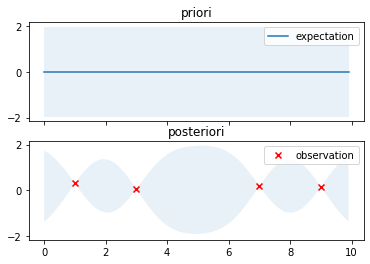

In [101]:
# init the priori setting
f,ax = plt.subplots(2,1,sharex=True,sharey=True)
X_pre = np.arange(0,10,0.1)
mu_pre = np.zeros((len(X_pre),))
Sigma_pre = RBF_kernel(X_pre,X_pre)
conf_interval = 1.96 * np.sqrt(np.diag(Sigma_pre)) # 95% confidence interval

ax[0].fill_between(X_pre,mu_pre+conf_interval,mu_pre-conf_interval,alpha=0.1)
ax[0].plot(X_pre,Y_pre,label="expectation")
ax[0].set_title('priori')
ax[0].legend()

# get the posteriori setting
X = np.array([1,3,7,9]) # observation time point
Y = getY(X)
Xt = X_pre # non-observation time point
mu_star,Sigma_star = update(X,Xt,Y)
conf_interval = 1.96 * np.sqrt(np.diag(Sigma_star))

ax[1].fill_between(Xt,mu_star+conf_interval,mu_star-conf_interval,alpha=0.1)
ax[1].scatter(X,Y,label="observation",c='r',marker='x')
ax[1].set_title('posteriori')
ax[1].legend()
plt.show()